## 起始設定

In [5]:
import talib
import numpy as np
import pandas as pd
from finlab.data import Data

folder = '/Volumes/Macintosh HD/history'

stock_id = '2412'

data = Data(folder)

## 取得預設持有報酬率

In [6]:
open_adj = data.get_adj('開盤價')

profit1 =  open_adj.shift(-2) / open_adj.shift(-1)
profit5 =  open_adj.shift(-6) / open_adj.shift(-1)
profit10 = open_adj.shift(-11) / open_adj.shift(-1)
profit60 = open_adj.shift(-61) / open_adj.shift(-1)

profit1 = profit1.unstack()
profit5 = profit5.unstack()
profit10 = profit10.unstack()
profit60 = profit60.unstack()


## 分析candlestick

In [7]:
from talib import abstract

strategies = {}
signals = {}

candlesticks = [fname for fname in dir(abstract) if fname[:3] == 'CDL']

for index, fname in enumerate(candlesticks, 1):
    print(f'{index}/{len(candlesticks)}: {fname} is running')

    df = data.talib(fname)
    df = df.unstack()
    df = df[df!= 0]

    stock_series = df.dropna(axis=0)

    if stock_series.empty:
        continue

    pos = stock_series > 0
    neg = stock_series < 0
    
    # profit 用cumprod 算出總報酬率
    # 用mean 可算出該蠟燭形態 的報酬率都落在什麼位置
    # mean 大於 1 至少可說這報酬率是正值 會賺錢
    strategies[fname] = {
        "positive_profit_1": profit1.loc[pos.index].unstack(level=0).mean(),
        "positive_profit_5": profit5.loc[pos.index].unstack(level=0).mean(),
        "positive_profit_10": profit10.loc[pos.index].unstack(level=0).mean(),
        "negative_profit_1": profit1.loc[neg.index].unstack(level=0).mean(),
        "negative_profit_5": profit5.loc[neg.index].unstack(level=0).mean(),
        "negative_profit_10": profit10.loc[neg.index].unstack(level=0).mean(),
    }
    
    signals[fname] = {
        "positive": stock_series[pos],
        "negative": stock_series[neg]
    }

1/61: CDL2CROWS is running
2/61: CDL3BLACKCROWS is running
3/61: CDL3INSIDE is running
4/61: CDL3LINESTRIKE is running
5/61: CDL3OUTSIDE is running
6/61: CDL3STARSINSOUTH is running
7/61: CDL3WHITESOLDIERS is running
8/61: CDLABANDONEDBABY is running
9/61: CDLADVANCEBLOCK is running
10/61: CDLBELTHOLD is running
11/61: CDLBREAKAWAY is running
12/61: CDLCLOSINGMARUBOZU is running
13/61: CDLCONCEALBABYSWALL is running
14/61: CDLCOUNTERATTACK is running
15/61: CDLDARKCLOUDCOVER is running
16/61: CDLDOJI is running
17/61: CDLDOJISTAR is running
18/61: CDLDRAGONFLYDOJI is running
19/61: CDLENGULFING is running
20/61: CDLEVENINGDOJISTAR is running
21/61: CDLEVENINGSTAR is running
22/61: CDLGAPSIDESIDEWHITE is running
23/61: CDLGRAVESTONEDOJI is running
24/61: CDLHAMMER is running
25/61: CDLHANGINGMAN is running
26/61: CDLHARAMI is running
27/61: CDLHARAMICROSS is running
28/61: CDLHIGHWAVE is running
29/61: CDLHIKKAKE is running
30/61: CDLHIKKAKEMOD is running
31/61: CDLHOMINGPIGEON is runni

In [8]:
for name, signal in signals.items():
    print(name)
    print('positive: ' + str(len(signal['positive'])))
    print('negative: ' + str(len(signal['negative'])))

CDL2CROWS
positive: 0
negative: 2731
CDL3BLACKCROWS
positive: 0
negative: 2213
CDL3INSIDE
positive: 25017
negative: 11786
CDL3LINESTRIKE
positive: 702
negative: 673
CDL3OUTSIDE
positive: 21470
negative: 70241
CDL3STARSINSOUTH
positive: 16
negative: 0
CDL3WHITESOLDIERS
positive: 2557
negative: 0
CDLABANDONEDBABY
positive: 169
negative: 175
CDLADVANCEBLOCK
positive: 0
negative: 8103
CDLBELTHOLD
positive: 464464
negative: 583064
CDLBREAKAWAY
positive: 91
negative: 134
CDLCLOSINGMARUBOZU
positive: 378972
negative: 487471
CDLCONCEALBABYSWALL
positive: 8
negative: 0
CDLCOUNTERATTACK
positive: 6255
negative: 8407
CDLDARKCLOUDCOVER
positive: 0
negative: 16335
CDLDOJI
positive: 910802
negative: 0
CDLDOJISTAR
positive: 38145
negative: 41512
CDLDRAGONFLYDOJI
positive: 137883
negative: 0
CDLENGULFING
positive: 54282
negative: 151201
CDLEVENINGDOJISTAR
positive: 0
negative: 4224
CDLEVENINGSTAR
positive: 0
negative: 12709
CDLGAPSIDESIDEWHITE
positive: 16743
negative: 16328
CDLGRAVESTONEDOJI
positive

## 將所有報酬率統整到dataframe
用 Multiple Index 的方式 將 candle stick name & stock id 作為 indies 
並且用各種profit當作 column 組合出一個dataframe

In [8]:
df_ = []
candlesitck_names = []
for candlesitck in strategies:
    df = pd.DataFrame(strategies[candlesitck])
    candlesitck_names.append(candlesitck)
    df_.append(df)

df_total = pd.concat(df_, keys=candlesitck_names, axis=0)

# 將 mutiple index 依照類型命名
df_total.index.names = ['candlestick', df_total.index.names[1]]
df_total

# df_total.plot()

positive_profit_1  positive_profit_5  \
candlestick                                                      
CDL2CROWS           0050           0.997219           0.977666   
                    0051           1.003568           0.997190   
                    0052           0.981431           0.970361   
                    0053           0.997887           0.996461   
                    0054           0.999762           0.998392   
...                                     ...                ...   
CDLXSIDEGAP3METHODS 9950           0.988552           0.978522   
                    9951           1.042254           1.056338   
                    9955           0.960280           0.883178   
                    9958           0.951263           1.045020   
                    9960           0.963220           0.949647   

                          positive_profit_10  negative_profit_1  \
candlestick                                                       
CDL2CROWS           0050            0.985989           0.997219   
                    0051            0.963726           1.003568   
                    0052            0.971178           0.981431   
                    0053            1.004212           0.997887   
                    0054            1.013641           0.999762   
...                                      ...                ...   
CDLXSIDEGAP3METHODS 9950            0.967826           0.988552   
                    9951            1.084507           1.042254   
                    9955            0.981308           0.960280   
                    9958            1.049189           0.951263   
                    9960            0.853866           0.963220   

                          negative_profit_5  negative_profit_10  
candlestick                                                      
CDL2CROWS           0050           0.977666            0.985989  
                    0051           0.997190            0.963726  
                    0052           0.970361            0.971178  
                    0053           0.996461            1.004212  
                    0054           0.998392            1.013641  
...                                     ...                 ...  
CDLXSIDEGAP3METHODS 9950           0.978522            0.967826  
                    9951           1.056338            1.084507  
                    9955           0.883178            0.981308  
                    9958           1.045020            1.049189  
                    9960           0.949647            0.853866  

[91494 rows x 6 columns]

## 取得所有策略的平均報酬率

In [9]:
stock_id = '2374'

profit_series = df_total.mean(axis=1)

# 取得正負報酬率統計
pos_profit = profit_series[profit_series > 1].mean(level=0)
neg_profit = profit_series[profit_series < 1].mean(level=0)

pos_profit_stk = profit_series[profit_series > 1].loc[:, [stock_id]].mean(level=0)
neg_profit_stk = profit_series[profit_series < 1].loc[:, [stock_id]].mean(level=0)

# 按照報酬率排序
neg_profit = neg_profit.sort_values(ascending=True)
pos_profit = pos_profit.sort_values(ascending=False)

pos_profit_stk = pos_profit_stk.sort_values(ascending=False)
neg_profit_stk = neg_profit_stk.sort_values(ascending=True)

### 選擇 candlestick

In [10]:
from finlab import crawler
from talib import abstract

top_rank = []

candlesticks = [fname for fname in dir(abstract) if fname[:3] == 'CDL']

for index, fname in enumerate(candlesticks, 1):
    candlesticks = crawler.crawl_candlestick_rank(fname)
    for candlestick_dict in candlesticks:
        print(f'{fname} - {candlestick_dict["candlestick"]} - overall performance rank: {candlestick_dict["overall_performance_rank"]}')
        candlestick_dict['talibname'] = fname
        top_rank.append(candlestick_dict)


CDL2CROWS - Two Crows - overall performance rank: 61
CDL3BLACKCROWS - Three Black Crows - overall performance rank: 3
CDL3INSIDE - Three Inside Up - overall performance rank: 20
CDL3INSIDE - Three Inside Down - overall performance rank: 56
CDL3LINESTRIKE - Bearish Three-Line Strike - overall performance rank: 1
CDL3LINESTRIKE - Bullish Three-Line Strike - overall performance rank: 2
CDL3OUTSIDE - Three Outside Up - overall performance rank: 34
CDL3OUTSIDE - Three Outside Down - overall performance rank: 39
CDL3STARSINSOUTH - Three Stars in the South - overall performance rank: 103
CDL3WHITESOLDIERS - Three White Soldiers - overall performance rank: 32
CDLABANDONEDBABY - Bulkowski's Bearish Abandoned Baby - overall performance rank: 64
CDLABANDONEDBABY - Bulkowski's Bullish Abandoned Baby - overall performance rank: 9
CDLADVANCEBLOCK - Bulkowski's Advance Block - overall performance rank: 54
CDLBELTHOLD - Bullish Belt Hold - overall performance rank: 62
CDLBELTHOLD - Bearish Belt Hold -

In [1]:
import pandas as pd
df = pd.DataFrame(top_rank)
df = df[df['theoretical_performance'] != '']
df['overall_performance_rank'] = df['overall_performance_rank'].astype(int)

df = df.sort_values(by=['overall_performance_rank'])

neg_candlestick = df[df['theoretical_performance'].str.contains('Bearish reversal')].head(20)['talibname'].to_list()

pos_candlestick = df[df['theoretical_performance'].str.contains('Bullish reversal')].head(10)['talibname'].to_list()

# top_rank

NameError: name 'top_rank' is not defined

In [ ]:
# 取出要計算策略的candlestick
# pos_candlestick = pos_profit_stk.head(3).index.to_list()

# neg_candlestick = neg_profit_stk.head(2).index.to_list()

In [ ]:
# 計算持有時間

choosen_candlesticks = set(pos_candlestick + neg_candlestick)

hold = pd.DataFrame(np.nan, index=open_adj.index, columns=choosen_candlesticks)

for candlestick, signal in signals.items():    
    if not candlestick in pos_candlestick:
        continue

    # 買入的時機
    sig = signals[candlestick]['positive']
    sig.index.names = ['stock_id', sig.index.names[1]]
    sig = sig.loc[[stock_id], :].droplevel(level=0)
    hold.loc[sig.index, [candlestick]] = hold.loc[sig.index, [candlestick]].add(1, fill_value = 0)
    # print(hold.loc[sig.index, [candlestick]])

for candlestick, signal in signals.items():    
    if not candlestick in neg_candlestick:
        continue
    
    # 賣出的時機 
    sig = signals[candlestick]['negative']
    sig.index.names = ['stock_id', sig.index.names[1]]
    sig = sig.loc[[stock_id], :].droplevel(level=0)
    hold.loc[sig.index, [candlestick]] = hold.loc[sig.index, [candlestick]].add(-1, fill_value = 0)
    # print(hold.loc[sig.index, [candlestick]])

hold = hold.ffill()
hold = hold.fillna(0)
hold_ = hold.sum(axis=1)
hold_ = hold_.shift()
hold_[hold_ > 0] = 1 
hold_[hold_ < 0] = 0

hold_.plot()

# profit_series.loc[:, [stock_id]]
# neg_profit_stk[candlesitck]

## 計算報酬率

In [4]:
import matplotlib.pyplot as plt

ret =  open_adj.shift(-1) / open_adj
ret = ret.fillna(1)
ret = ret[stock_id]
ret_expect = ret.cumprod()
ax1 = ret_expect.plot(label='always taken')
h1, l1 = ax1.get_legend_handles_labels()

ret[hold_ != 1]= np.nan
ret_final = ret.fillna(1).cumprod()
ax2 = ret_final.plot(label='candlestick stategy')
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h2, l2, loc=2)
plt.show()

NameError: name 'open_adj' is not defined

## 考慮手續費

### rebalance 找出買進賣出的時機點
依靠 hold 持有的變化 找出買進賣出的時間, 並將 每個時間區間點做group by  
就可以計算第一個時間點到第二個時間點前的報酬率  
分組計算報酬率後，就可以說是持有時的報酬率
> ps : 請看最下面的解釋範例

In [15]:
# 計算實際買入賣出報酬率
rebalance = (hold_.diff().abs() != 0).cumsum()
rebalance_hold = hold_[rebalance.diff() != 0]

扣掉tax_ratio date
2007-04-23    1.000000
2007-04-24    1.000000
2007-05-03    1.135089
2007-05-21    0.995575
2007-08-15    1.232955
2007-10-18    0.995575
2008-09-08    1.804414
2011-01-13    0.995575
2016-10-03    0.982655
dtype: float64
tax_ratio date
2007-05-03    0.001425
2007-05-21    0.004425
2007-08-15    0.001425
2007-10-18    0.004425
2008-09-08    0.001425
2011-01-13    0.004425
2016-10-03    0.001425
dtype: float64
沒有扣掉tax_ratio date
2007-04-23    1.000000
2007-04-24    1.000000
2007-05-03    1.136709
2007-05-21    1.000000
2007-08-15    1.234715
2007-10-18    1.000000
2008-09-08    1.806989
2011-01-13    1.000000
2016-10-03    0.984058
Name: 2374, dtype: float64


date
2007-04-23    1.000000
2007-04-24    1.000000
2007-05-03    1.136709
2007-05-21    1.136709
2007-08-15    1.403511
2007-10-18    1.403511
2008-09-08    2.536130
2011-01-13    2.536130
2016-10-03    2.495698
Name: 2374, dtype: float64

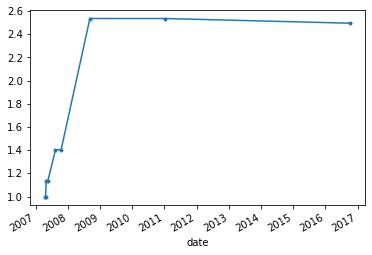

In [60]:
# 手續費
## 交易買入賣出時要計算手續費
# position_diff = rebalance_hold.div(rebalance_hold.sum(), axis=0).fillna(0).diff()
position_diff = rebalance_hold.fillna(0).diff().fillna(0)

tax_ratio = pd.Series(np.nan, index=ret.index)
tax_ratio.loc[position_diff.index] = position_diff
tax_ratio[tax_ratio < 0] *= (1.425/1000 + 3/1000)
tax_ratio[tax_ratio > 0] *= (1.425/1000)
tax_ratio = tax_ratio.abs().fillna(0)

r = ret.copy().fillna(1)
r = r * (1 - tax_ratio)

rebalance_gain = r.groupby(rebalance.values).apply(lambda s:s.cumprod().iloc[-1])
rebalance_gain.index = rebalance_hold.index
print('扣掉tax_ratio', rebalance_gain)
print('tax_ratio', tax_ratio[tax_ratio > 0])
r = ret.copy().fillna(1)
rebalance_gain = r.groupby(rebalance.values).apply(lambda s:s.cumprod().iloc[-1])
rebalance_gain.index = rebalance_hold.index

print('沒有扣掉tax_ratio', rebalance_gain)
# 老師範例平均是為了多檔股票的報酬率取平均, 此處只有一股不需做平均
# rebalance_hold==1 是計算買入的報酬率，賣出後是沒有報酬率的
# eq2 = (rebalance_gain[rebalance_hold == 1].mean() * (1 - tax_ratio)).cumprod()

# TODO [rebalance_hold == 1] 代表的是買入，這樣不就只有算到買入的手續費用
# 賣出的手續費用不就都沒算到？
eq2 = rebalance_gain.cumprod()
eq2.plot(style='.-')
eq2

In [18]:
# 以數據解釋持有變化
# rebalance印出的row代表持有變化的日期
r = rebalance[rebalance.diff() != 0]
print(r)
# 則若hold將對應的日期顯示 應該呈現 0 -> 1  -> 0  -> 1的循環
# 表示買入買出
hold_[r.index]

date
2007-04-23    1
2007-04-24    2
2007-05-03    3
2007-05-21    4
2007-08-15    5
2007-10-18    6
2008-09-08    7
2011-01-13    8
2016-10-03    9
dtype: int64


date
2007-04-23    NaN
2007-04-24    0.0
2007-05-03    1.0
2007-05-21    0.0
2007-08-15    1.0
2007-10-18    0.0
2008-09-08    1.0
2011-01-13    0.0
2016-10-03    1.0
dtype: float64

date
2007-04-23         NaN
2007-04-24         NaN
2007-05-03    1.135089
2007-05-21         NaN
2007-08-15    1.399514
2007-10-18         NaN
2008-09-08    2.525303
2011-01-13         NaN
2016-10-03    2.481503
dtype: float64

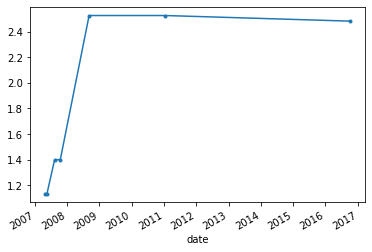

In [56]:
# 手續費
## 交易買入賣出時要計算手續費
# position_diff = rebalance_hold.div(rebalance_hold.sum(), axis=0).fillna(0).diff()
position_diff = rebalance_hold.fillna(0).diff().fillna(0)

tax_ratio = position_diff.copy()
# tax_ratio.loc[position_diff.index] = position_diff
tax_ratio[tax_ratio < 0] *= (1.425/1000 + 3/1000)
tax_ratio[tax_ratio > 0] *= (1.425/1000)
tax_ratio = tax_ratio.abs().fillna(0)

r = ret.copy().fillna(1)

rebalance_gain = r.groupby(rebalance.values).apply(lambda s:s.cumprod().iloc[-1])
rebalance_gain.index = rebalance_hold.index

# 老師範例平均是為了多檔股票的報酬率取平均, 此處只有一股不需做平均
# rebalance_hold==1 是計算買入的報酬率，賣出後是沒有報酬率的
# eq2 = (rebalance_gain[rebalance_hold == 1].mean() * (1 - tax_ratio)).cumprod()
eq2 =  (rebalance_gain[rebalance_hold == 1] * (1 - tax_ratio)).cumprod()
eq2.ffill().plot(style='.-')
eq2